In [1]:
import pandas as pd

In [2]:
df_train = pd.read_csv('data_text2bank/cs_banking77/banking-train-translated.csv')
df_test = pd.read_csv('data_text2bank/cs_banking77/banking-test-translated.csv')
df_val = pd.read_csv('data_text2bank/cs_banking77/banking-val-translated.csv')

df_train.shape[0] + df_test.shape[0] + df_val.shape[0]

13242

In [3]:
b77 = pd.concat([df_train, df_test, df_val])
b77['kategorie'] = b77['kategorie'].str.lower()
b77 = b77.sort_values('kategorie').reset_index(drop=True)

In [4]:
b77 = b77.drop_duplicates('text')
selected = pd.read_csv('selected_classes.csv')
b77 = b77[b77['category'].isin(selected['en'])]

In [5]:
# replace names with correct cz

for r in selected.iterrows():
    en = r[1]['en']
    cz = r[1]['cz']
    if type(cz) == str:
        idc = b77[b77['category'] == en].index
        b77.loc[idc, 'kategorie'] = cz

In [6]:
t2b = pd.read_csv('data_text2bank/clean-pairs-enhanced-sort-22-03-23.csv').dropna()
t2b.columns = ['text_cz', 'kategorie']
t2b = t2b.drop_duplicates('text_cz')

# from previous analysis - remove and merge

t2b = t2b[t2b['kategorie'] != 'limity']
t2b['kategorie'] = t2b['kategorie'].str.replace('ztratil jsem platební kartu', 'ztracená nebo odcizená karta')
t2b['kategorie'] = t2b['kategorie'].str.replace('čekající platby', 'čekající převod')

t2b['text_cz'] = t2b['text_cz'].str.capitalize()

t2b.groupby('kategorie').count().sort_values('text_cz')

text_cz
kategorie                                       
čekající převod                               23
ztracená nebo odcizená karta                  32
sjednat schůzku na pobočce                    82
trvalé platby                                 86
jednorázová platba tuzemská                   87
chci půjčit/kolik mi půjčíte                  89
svolení k inkasu a sipo                       89
splátka kreditní karty                        92
potřebuji potvrzení o platbě                  93
sjednat hypotéku                              96
potřebuji mimořádnou splátku (hypotéky)      102
výpisy                                       109

In [7]:
df_merged = pd.concat([b77, t2b]).reset_index()

<AxesSubplot:xlabel='kategorie'>

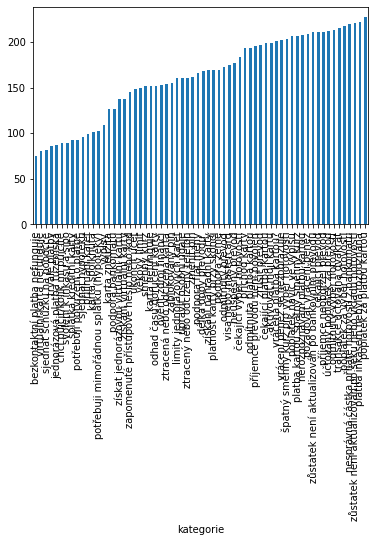

In [8]:
pd.set_option('display.max_rows', 80)
df_merged.groupby('kategorie').count()['index'].sort_values().plot.bar(x='kategorie', y='index')

In [10]:
df_merged.to_csv('data_text2bank/merged-2022-03-24.csv', index=False)

# import pandas as pd
# df_merged = pd.read_csv('data_text2bank/merged-2022-03-24.csv')

## Distribucia poctu vzoriek pre triedu

In [4]:
import matplotlib.pyplot as plt

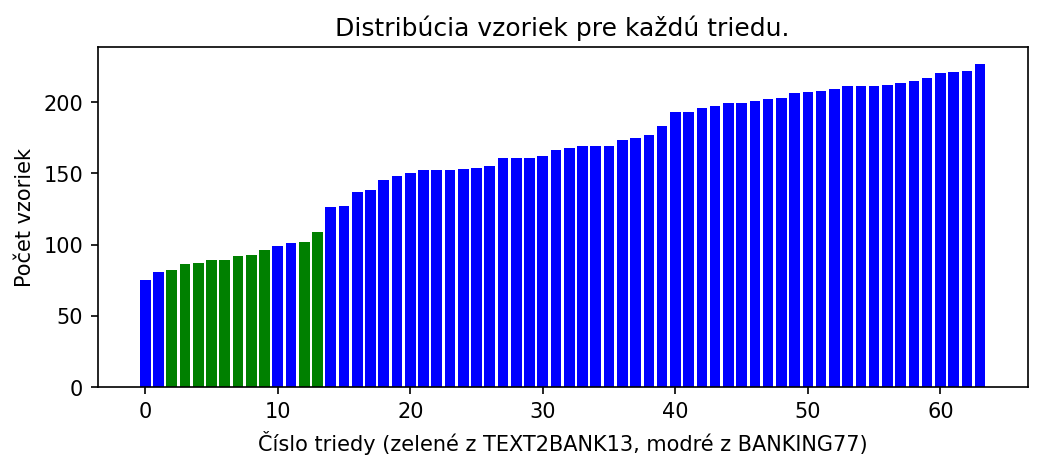

In [8]:
t2b = pd.read_csv('data_text2bank/clean-pairs-enhanced-sort-22-03-23.csv').dropna()
t2b.columns = ['text_cz', 'kategorie']
kat = t2b['kategorie'].unique()

dist = df_merged.groupby('kategorie').count()['index'].sort_values()

colors = ['green' if k else 'blue' for k in dist.index.isin(kat)]

plt.figure(dpi=150, figsize=(8,3))
plt.bar(x=list(range(len(dist.index))), height=dist, color=colors)
plt.xlabel('Číslo triedy (zelené z TEXT2BANK13, modré z BANKING77)')
plt.ylabel('Počet vzoriek')
plt.title(label='Distribúcia vzoriek pre každú triedu.')
plt.show()

## podobnost intentov ako klasifikator


In [21]:
from laserembeddings import Laser
laser = Laser()

In [22]:
laser_embs = laser.embed_sentences(df_merged['text_cz'], lang='cs')

In [23]:
df_merged['laser'] = pd.Series(laser_embs.tolist())

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_merged['laser'].tolist(), df_merged['kategorie'].tolist(), train_size=0.8)

# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

In [25]:
# X_train[:10].shape, len(first_test)

cos_simil = cosine_similarity(X_train, [X_test[0]])

In [26]:
cos_simil.flatten().max()

0.842637039406742

In [27]:
X_test[0], X_train[2281]

([0.015967190265655518,
  0.0005519409314729273,
  0.002062968211248517,
  0.00885759387165308,
  0.01165013387799263,
  0.011228347197175026,
  0.017020829021930695,
  0.01073042768985033,
  0.008896633051335812,
  0.001186536275781691,
  0.03653339669108391,
  0.005378257483243942,
  0.0010222905548289418,
  0.013901005499064922,
  0.0052674380131065845,
  0.009182343259453773,
  0.031133433803915977,
  0.010891765356063843,
  0.0009716417407616973,
  -0.00010913856385741383,
  0.008576923049986362,
  0.09715042263269424,
  -6.728154858137714e-06,
  0.047108255326747894,
  0.02719494327902794,
  0.009623047895729542,
  0.00792565755546093,
  0.001125301350839436,
  0.03245072439312935,
  0.004663596395403147,
  0.0410001315176487,
  -6.363527791108936e-05,
  0.00047076650662347674,
  0.006621034350246191,
  0.057306285947561264,
  0.026224123314023018,
  0.0005808296264149249,
  0.016584526747465134,
  0.007065034471452236,
  0.00036664720391854644,
  0.027533309534192085,
  0.036691

In [51]:
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          BertTokenizer, DataCollatorWithPadding, AutoTokenizer)
from pathlib import Path

In [121]:
CZERT_MODEL_PATH = Path.cwd() / Path("CZERT-B-v2-czert-bert-base-cased/czert-bert-base-cased--2020-10-06")
# CZERT_MODEL_PATH = Path.cwd() / Path("CZERT-A-v2-czert-albert-base-uncased/czert-base-uncased")

tokenizer = BertTokenizer.from_pretrained(CZERT_MODEL_PATH / 'vocab.txt', strip_accents=False, do_lower_case=False)

/home/sfabo/.pyenv/versions/3.8.12/envs/dip/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1658: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(


In [122]:
longest = df_merged.loc[df_merged['text_cz'].str.contains(r'00', regex=True), 'text_cz'].iloc[0]

In [126]:
tokenizer.tokenize('Poslat Martinovi $ CZK'), tokenizer.tokenize('Poslat Martinovi $ CZK'.lower())

(['Pos', '##lat', 'Martin', '##ovi', '$', 'CZ', '##K'],
 ['poslat', 'mar', '##tin', '##ovi', '$', 'cz', '##k'])

In [1]:

import pandas as pd
df_merged = pd.read_csv('data_text2bank/merged-2022-03-24.csv')

In [2]:
g = df_merged.groupby('kategorie').agg(['nunique', 'count'])['text_cz']
g['delta'] = g['count'] - g['nunique']
g.sort_values('delta')

nunique  count  delta
kategorie                                                     
špatný směnný kurz pro výběr hotovosti       203    203      0
trvalé platby                                 86     86      0
svolení k inkasu a sipo                       89     89      0
potřebuji mimořádnou splátku (hypotéky)      102    102      0
sjednat schůzku na pobočce                    82     82      0
...                                          ...    ...    ...
podpora země                                 158    169     11
získání virtuální karty                      127    138     11
visa nebo mastercard                         164    175     11
odmítnuta platba kartou                      182    193     11
směnný kurz                                  138    152     14

[64 rows x 3 columns]

## OOD detection?

In [7]:
from pathlib import Path
from datasets import ClassLabel, Features, Value, DatasetDict, Dataset
from sklearn.model_selection import train_test_split

def load_merged_banking(banking_dir: Path):
    
    df_merged = pd.read_csv(banking_dir)
    
    cat2label = {k: v for v, k in enumerate(df_merged['kategorie'].unique())}
    df_merged['labels'] = df_merged['kategorie'].map(cat2label)
    
    df_merged_tr, df_merged_tmp = train_test_split(df_merged, train_size=0.8, random_state=42, stratify=df_merged[['kategorie']])
    df_merged_te, df_merged_va = train_test_split(df_merged_tmp, train_size=0.5, random_state=42, stratify=df_merged_tmp[['kategorie']])
    

    banking_features = Features({
        'text_cz': Value('string'), 
        'kategorie': Value('string'), 
        'labels': ClassLabel(names=list(cat2label.keys()))
    })
    
    merged = DatasetDict({
        'train': Dataset.from_pandas(df_merged_tr, features=banking_features),
        'test': Dataset.from_pandas(df_merged_te, features=banking_features),
        'valid': Dataset.from_pandas(df_merged_va, features=banking_features)
    })
    
    return merged


In [8]:
ds =  load_merged_banking(Path('data_text2bank/merged-2022-03-24.csv'))

In [16]:
ds

DatasetDict({
    train: Dataset({
        features: ['text_cz', 'kategorie', 'labels'],
        num_rows: 8285
    })
    test: Dataset({
        features: ['text_cz', 'kategorie', 'labels'],
        num_rows: 1036
    })
    valid: Dataset({
        features: ['text_cz', 'kategorie', 'labels'],
        num_rows: 1036
    })
})

### LASER

In [10]:
from laserembeddings import Laser
laser = Laser()

tr_embs = laser.embed_sentences(ds['train']['text_cz'], lang='cs')
va_embs = laser.embed_sentences(ds['valid']['text_cz'], lang='cs')

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

cs = cosine_similarity(tr_embs, va_embs)

In [20]:
len(ds['valid'])

1036

In [21]:
res = [ds['train']['kategorie'][cs[:, i].argmax()] == ds['valid']['kategorie'][i] for i in range(len(ds['valid']))]

In [23]:
import numpy as np

np.mean(res)

0.8648648648648649

### Read OOD set

In [74]:
o = pd.read_csv('/home/sfabo/Projects/DIP/query_202204121034.csv')
o = o['input'].dropna().unique()

In [31]:
o_emb = laser.embed_sentences(o, lang='cs')

In [32]:
cs = cosine_similarity(tr_embs, o_emb)

In [42]:
sorted([(cs[:,i].max(), ds['train']['kategorie'][cs[:,i].argmax()], o[i]) for i in range(len(o))], key=lambda x: x[0])

[(0.61689377, 'svolení k inkasu a sipo', 'EWDFDSFDSF'),
 (0.6183149, 'příjemce neobdržel převod', 'obchodník nepodporuje 3D secure'),
 (0.64401907,
  'příjemce převodu není povolen',
  'Ahoj chatbot, chcela by som si kúpiť NFT, dá sa to?'),
 (0.6547534, 'svolení k inkasu a sipo', 'QWFGHJK./'),
 (0.65552175,
  'zablokovaný pin',
  'Ahoj chatbot, karta mi dorazila na špatnú adresu, pomoc'),
 (0.65597284, 'visa nebo mastercard', 'ASFDGHJKL,.'),
 (0.6592897,
  'platba kartou špatný směnný kurz',
  'Kedy mate otvorenu pobicku vo Vysnych Ruzbachoch?'),
 (0.66162616, 'jednorázová platba tuzemská', 'test1'),
 (0.6717079,
  'vrácení peněz se nezobrazuje',
  'Potrebujem pozicat peniaze lebo nemam a manzelka chce dake oblecenie zas'),
 (0.67951053, 'podpora fiat měny', 'za kolik korun koupím eura'),
 (0.68455124, 'svolení k inkasu a sipo', "QEWARESTRDYFGUHLI';"),
 (0.6879034, 'délka doby převodu ', 'Aký je kurz na poľské zloty?'),
 (0.6926716, 'svolení k inkasu a sipo', 'cau kamo'),
 (0.71312237,

### FASTTEXT

In [47]:
import fasttext
ft = fasttext.load_model('/home/sfabo/Projects/DIP/cc.cs.300.bin')

In [48]:
def ft_sent(texts):
    return [ft.get_sentence_vector(c) for c in texts]

In [64]:
tr_embs_ft = ft_sent(df_merged['text_cz'])
o_emb_ft = ft_sent([oo.strip() for oo in o.tolist()])

cs = cosine_similarity(tr_embs_ft, o_emb_ft)

In [66]:
sorted([(cs[:,i].max(), o[i], df_merged['kategorie'][cs[:,i].argmax()]) for i in range(len(o))], key=lambda x: x[0])

[(0.14815758, 'ASFDGHJKL,.', 'změnit pin'),
 (0.18894053, 'QWFGHJK./', 'požadovat vrácení peněz'),
 (0.27835968, 'Directives', 'změnit pin'),
 (0.2834311, 'aba', 'zapomenuté přístupové heslo nebo kód'),
 (0.29172122, 'Outdoors', 'visa nebo mastercard'),
 (0.29851532, 'Leone', 'visa nebo mastercard'),
 (0.31358898, 'EWDFDSFDSF', 'příjemce převodu není povolen'),
 (0.32938862, 'previod', 'karta zneužita'),
 (0.3615663, 'ASDASDASDAS', 'potřebuji potvrzení o platbě'),
 (0.3753955, 'encoding', 'svolení k inkasu a sipo'),
 (0.3768749, 'test1', 'zapomenuté přístupové heslo nebo kód'),
 (0.37868395, 'Dndb', 'karta nefunguje'),
 (0.38676578, 'Zeptat', 'odhad času doručení karty'),
 (0.39330167, 'Direct', 'svolení k inkasu a sipo'),
 (0.43054298, 'cau kamo', 'sjednat schůzku na pobočce'),
 (0.4332593, 'Chod dopici', 'platba inkasem nebyla rozpoznána'),
 (0.43449616, 'ASDASDSAD', 'aktivovat moji kartu'),
 (0.43546414, 'mezinarodni prevod', 'jednorázová platba tuzemská'),
 (0.46061572, "QEWARESTRD

In [75]:
from nb_query_eval import Tokenizer

tkz = Tokenizer('/home/sfabo/Projects/DIP/nb_query_eval/resources/stopwords.txt')

def tokenize(tkz, texts):
    return [' '.join([w for w, v in tkz.fit(t) if v == 'KW']) for t in texts]


tr_embs_ft = ft_sent(tokenize(tkz, df_merged['text_cz']))
o_emb_ft = ft_sent([oo.strip() for oo in tokenize(tkz, o)])

cs = cosine_similarity(tr_embs_ft, o_emb_ft)
sorted([(cs[:,i].max(), o[i], df_merged['kategorie'][cs[:,i].argmax()]) for i in range(len(o))], key=lambda x: x[0])

[(0.0, 'QWFGHJK./', 'aktivovat moji kartu'),
 (0.0, 'test1', 'aktivovat moji kartu'),
 (0.0, '1+1', 'aktivovat moji kartu'),
 (0.13590224, 'dcdc', 'ztracený nebo odcizený telefon'),
 (0.19727534, 'dwedw', 'visa nebo mastercard'),
 (0.2088738, 'wedw', 'visa nebo mastercard'),
 (0.21905872, "QEWARESTRDYFGUHLI';", 'jednorázová platba tuzemská'),
 (0.23698193, 'sdfbv dsfv ', 'upravit osobní údaje'),
 (0.2496336, 'Dndb', 'platba inkasem nebyla rozpoznána'),
 (0.26677674, 'sdvsdv', 'bezkontaktní platba nefunguje'),
 (0.27505973, 'wcdw', 'visa nebo mastercard'),
 (0.28047162, 'aba', 'jednorázová platba tuzemská'),
 (0.28964067, 'Outdoors', 'svolení k inkasu a sipo'),
 (0.29728094, 'Directives', 'svolení k inkasu a sipo'),
 (0.3221206, 'Leone', 'visa nebo mastercard'),
 (0.3311576, 'nnnnn', 'splátka kreditní karty'),
 (0.33697712, 'ASFDGHJKL,.', 'jednorázová platba tuzemská'),
 (0.34498417, 'EWDFDSFDSF', 'jednorázová platba tuzemská'),
 (0.34814045, 'sdcdc', 'jednorázová platba tuzemská'),
 (0

In [4]:
import fasttext
from sklearn.metrics.pairwise import cosine_similarity
from nb_query_eval import Tokenizer
import pandas as pd
from pathlib import Path


# knowledge_base_cat = ds['train']['kategorie']
# knowledge_base = ds['train']['text_cz']
# to_verify = ds['valid']['text_cz']
# knowledge_base_cat = df_merged['kategorie']
# knowledge_base = df_merged['text_cz']
# to_verify = o


tkz = Tokenizer(
    '/home/sfabo/Projects/DIP/nb_query_eval/resources/stopwords.txt')
ft = fasttext.load_model('/home/sfabo/Projects/DIP/cc.cs.300.bin')


class ClassifierOOD:

    def __init__(self, knowledge_base: list, kb_categories: list, fasttext_obj=None, fasttext_path: Path = None, tokenizer=None):
        self.knowledge_base = knowledge_base
        self.knowledge_base_cat = kb_categories
        if fasttext_path is None:
            self.ft = fasttext_obj
        elif fasttext_obj is None:
            self.ft = fasttext.load_model(fasttext_path)
        else:
            raise ValueError(
                'fasttext_obj xOR fasttext_path should be defined!')
        self.tkz = tokenizer
        self.kb_embs = self._embedding_pipeline(knowledge_base)

    def _tokenize(self, texts):
        if self.tkz is not None:
            return [' '.join([w for w, v in self.tkz.fit(t) if v == 'KW']) for t in texts]
        else:
            return texts

    def _ft_sent(self, texts):
        return [self.ft.get_sentence_vector(c) for c in texts]

    def _embedding_pipeline(self, texts: list):
        clean_texts = self._tokenize(texts)
        return self._ft_sent(clean_texts)

    def get_kb_similarity(self, to_verify: list):
        to_verify_emb = self._embedding_pipeline(to_verify)
        cs = cosine_similarity(self.kb_embs, to_verify_emb)
        return [{
            'max_simil': cs[:, i].max(),
            'best_category': self.knowledge_base_cat[cs[:, i].argmax()]
        } for i in range(len(to_verify))
        ]


df_merged = pd.read_csv('data_text2bank/merged-2022-03-24.csv')
o = pd.read_csv('/home/sfabo/Projects/DIP/query_202204121034.csv')
o = o['input'].dropna().unique()

ood = ClassifierOOD(
    knowledge_base=df_merged['text_cz'],
    kb_categories=df_merged['kategorie'],
    fasttext_obj=ft,
    tokenizer=tkz)

o[0], ood.get_kb_similarity([o[0]])


# tr_embs_ft = ft_sent(tokenize(tkz, knowledge_base))
# o_emb_ft = ft_sent([oo.strip() for oo in tokenize(tkz, to_verify)])

# # tr_embs_ft = ft_sent(knowledge_base)
# # o_emb_ft = ft_sent([oo.strip() for oo in to_verify])

# cs = cosine_similarity(tr_embs_ft, o_emb_ft)
# sorted([(cs[:,i].max(), to_verify[i], knowledge_base_cat[cs[:,i].argmax()]) for i in range(len(to_verify))], key=lambda x: x[0])


('chci poslat peníze matce na její účet. bude to 200 korun',
 [{'max_simil': 0.84831417, 'best_category': 'příjemce převodu není povolen'}])

In [31]:
input = 'přečti mi pohádku'
input, ood.get_kb_similarity([input])

('přečti mi pohádku',
 [{'max_simil': 0.62445974, 'best_category': 'poplatek navíc ve výpisu'}])

### ROBECZECH

In [62]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('ufal/robeczech-base')

tr_embs_rc = model.encode(ds['train']['text_cz'])
o_emb_rc = model.encode(o)

cs = cosine_similarity(tr_embs_rc, o_emb_rc)

Some weights of the model checkpoint at /home/sfabo/.cache/torch/sentence_transformers/ufal_robeczech-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [63]:
sorted([(cs[:,i].max(), ds['train']['kategorie'][cs[:,i].argmax()], o[i]) for i in range(len(o))], key=lambda x: x[0])

[(0.8745071, 'karta spolknuta', 'Vykradnúť banku'),
 (0.879258, 'visa nebo mastercard', 'ASDASDASDAS'),
 (0.8828064, 'visa nebo mastercard', 'ASDASDSAD'),
 (0.88327754, 'potřebuji potvrzení o platbě', 'cau kamo'),
 (0.887047, 'svolení k inkasu a sipo', 'asdasdsadsa'),
 (0.8891457, 'sjednat schůzku na pobočce', 'Outdoors'),
 (0.8953321,
  'špatný směnný kurz pro výběr hotovosti',
  'Poslať peniaze do zahraničia '),
 (0.89572, 'svolení k inkasu a sipo', 'mezinarodni prevod'),
 (0.8997467, 'potřebuji potvrzení o platbě', 'Chod dopici'),
 (0.900245, 'čekající převod', 'previod'),
 (0.9033402, 'ztracená nebo odcizená karta', 'Zlomila sa mi debetna karta'),
 (0.9048054, 'podpora bankomatu', 'EWDFDSFDSF'),
 (0.90573126, 'svolení k inkasu a sipo', 'Directives'),
 (0.9106762, 'bezkontaktní platba nefunguje', 'Zabudol som heslo '),
 (0.91590804, 'podpora země', 'Kde najdu svuj pin'),
 (0.91967106, 'karta spolknuta', 'Dndb'),
 (0.91991246, 'karta spolknuta', 'Nemám na borovičku '),
 (0.9199226,
 